In [80]:
import os
import zipfile
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc # used to create a connection to SQL Server data base

import warnings
# Deactivate only the UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

Before running the script make sure to change the variable `table_name` before pushing data to SQL Server DB, as well as the `real_estate_df['date_snapshot'] = ` to the date the data was parsed.

## Stage 1: Load and merge JSON data into a DataFrame and create a flat table

In [81]:
# Directory where JSON files are located
json_folder = "Raw_data"

# List all files in the 'json_folder' variable with a .json extension
json_files = [f for f in os.listdir(json_folder) if f.endswith(".json")]

# Create an empty list to store the data from each file
data_from_json = []

# Loop through each JSON file and load its data into the `data_from_json` list
for file in json_files:
    with open(os.path.join(json_folder, file), "r") as f:
        data_from_json.append(json.load(f))

# Concatenate the items in the `data_from_json` list into a single list
merged_data = []
for data in data_from_json:
    merged_data += data

In [82]:
# Convert the merged data to a pandas DataFrame
full_df = pd.json_normalize(merged_data)
full_df.shape

(61894, 123)

In [83]:
specificatii_rows = []
for i, row in enumerate(full_df.to_dict('records')):
    try:
        specificatii_df = pd.json_normalize(
            row,
            record_path=['specificatii', 'elemente'], # define the unpacking order
            meta=['id', 'id_string', ['specificatii', 'titlu']] # specify the columns to keep. Include 'id' for subsequent merging.
        )
        specificatii_rows.append(specificatii_df)
    except TypeError as e:
        print(f"Error in row {i}: {e}")
        continue
        
specificatii_df = pd.concat(specificatii_rows, ignore_index=True)

In [84]:
# Remove duplicates as they usually appear due to missing values in some columns
specificatii_df.drop_duplicates(inplace=True)
specificatii_df.shape

(932791, 5)

In [85]:
# Create a copy of the data frame in order to perform value_counts and identify 'subtitlu'-ri to remove
subtitlu_to_delete = pd.DataFrame(specificatii_df)
# Apply title and strip methods to make the names uniform before computing their share
subtitlu_to_delete['subtitlu'] = subtitlu_to_delete['subtitlu'].apply(lambda x: x.title().strip())
subtitlu_to_delete['specificatii.titlu'] = subtitlu_to_delete['specificatii.titlu'].apply(lambda x: x.title().strip())
# Subset only relevant columns to keep and set value column name to 'share'
subtitlu_to_delete = subtitlu_to_delete.value_counts(subset=['specificatii.titlu', 'subtitlu'], normalize=True).to_frame('share')
# Compute the estimated share of non-missing values in the original data frame for each 'subtitlu'
subtitlu_to_delete['share_%_of_properties'] = subtitlu_to_delete['share'].apply(
                                                            lambda x: (x * specificatii_df.shape[0]) / full_df.shape[0])
# Reset index
subtitlu_to_delete.reset_index(drop=False, inplace=True)

In [86]:
# Check relative value to idenitify a benchmark for selecting columns to be deleted
subtitlu_to_delete.head(15)

,specificatii.titlu,subtitlu,share,share_%_of_properties
0,Utilități,Utilitati Generale,0.055738,0.840017
1,Alte Detalii Zonă,Amenajare Strazi,0.051466,0.775633
2,Utilități,Sistem Incalzire,0.050699,0.764081
3,Finisaje,Podele,0.048594,0.732349
4,Finisaje,Pereti,0.047747,0.719585
5,Finisaje,Usa Intrare,0.046598,0.702265
6,Finisaje,Ferestre Cu Geam Termopan,0.042516,0.640757
7,Alte Detalii Zonă,Mijloace De Transport In Comun,0.040646,0.612563
8,Dotări,Dotari Imobil,0.039799,0.599800
9,Alte Detalii Zonă,Iluminat Stradal,0.039485,0.595066


In [87]:
# Filter only the attributes that have less than 70% of total records as these are the most prone to create unuseful columns (with lots of Null)
subtitlu_to_delete = subtitlu_to_delete[subtitlu_to_delete['share_%_of_properties']<0.70]
# Save the attributes to be deleted to a list
subtitlu_to_delete = list(subtitlu_to_delete['subtitlu'])
# Clean the 'specificatii_df' data frame from attributes saved in the list
specificatii_df = specificatii_df.drop(specificatii_df[specificatii_df['subtitlu'].isin(subtitlu_to_delete)].index)

In [88]:
# Remove duplicates if they exist before applying the pivot function otherwise it will generate an error
specificatii_df.drop_duplicates(inplace=True)
# Create a long table using pivot method that will be used to merge 'specificatii_df' with the original data frame at ID level
specificatii_df = specificatii_df.pivot(index = ['id', 'id_string'], columns = 'subtitlu', values = 'valoare')
# Reset but keep Index (to make sure the later join is done with the right ids):
specificatii_df.reset_index(drop=False, inplace=True)
# Check shape
print(specificatii_df.shape)

(54505, 8)


In [89]:
# Merge both data frames using a Left Join on both 'id' and 'id_string' columns
real_estate_df = pd.merge(full_df, specificatii_df, on=['id', 'id_string'], how='left')
real_estate_df.shape

(61894, 129)

In [90]:
# Add the snapshot date related to period the info was gathered 
real_estate_df['date_snapshot'] = '28-08-2023' # dd-mm-yyyy

### Stage 2: Prepare the data set for BI

In [91]:
import pandas as pd
pd.set_option('display.max_rows', 200)

In [92]:
# Check general information about data frame
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61894 entries, 0 to 61893
Columns: 130 entries, id to date_snapshot
dtypes: bool(11), float64(6), int64(26), object(87)
memory usage: 57.3+ MB


In [93]:
# Inspecting null columns
real_estate_df.isna().sum()

id                                      0
id_string                               0
titlu                                   0
judet                                   0
localitate                              0
zona                                    0
comision                                0
latitudine                              0
longitudine                             0
status_publicare                        0
rang                                    0
licitatii                               0
data_intrare_in_piata                   0
pret_vanzare                            0
pret_vanzare_anterior                   0
pret_vanzare_referinta                  0
pret_vanzare_scazut                     0
pret_inchiriere                         0
pret_inchiriere_anterior                0
pret_inchiriere_referinta               0
pret_inchiriere_scazut                  0
poza_prezentare                         0
poze                                    0
mod_calcul_pret_vanzare           

In [94]:
# Extract total rows number of the data frame and assign it to a variable
total_rows = real_estate_df.shape[0]
# Get the missing info into a dataframe and name the column 'missing_values'
na_columns = real_estate_df.isna().sum().to_frame('missing_values')
# Reset index   
na_columns.reset_index(drop=False, inplace=True)
# Converting absolute nr of missing values into relative %
na_columns['missing_values'] = na_columns['missing_values'].apply(lambda x: x/total_rows) 

In [95]:
# Identify the columns that have over 80% of missing values
na_columns = na_columns[na_columns['missing_values']>=0.8]
# Save the potential columns to be deleted in a list
columns_to_remove = list(na_columns['index'])
# Removing columns that have at least 80% missing values
real_estate_df = real_estate_df.drop(labels=columns_to_remove, axis=1)

In [96]:
real_estate_df.isna().sum()

id                                      0
id_string                               0
titlu                                   0
judet                                   0
localitate                              0
zona                                    0
comision                                0
latitudine                              0
longitudine                             0
status_publicare                        0
rang                                    0
licitatii                               0
data_intrare_in_piata                   0
pret_vanzare                            0
pret_vanzare_anterior                   0
pret_vanzare_referinta                  0
pret_vanzare_scazut                     0
pret_inchiriere                         0
pret_inchiriere_anterior                0
pret_inchiriere_referinta               0
pret_inchiriere_scazut                  0
poza_prezentare                         0
poze                                    0
mod_calcul_pret_vanzare           

In [97]:
# Additional columns to delete:
delete_columns = ['an_constructie', # there is a similar one with more details 'an_constructie_text'
                  'anunt_verificat', # not relevant, only TRUE or FALSE
                  'ascunde_formular_contact', # TRUE or FALSE
                  'blackfriday', # TRUE or FALSE
                  'caroiaj', # used for projecting properties on the web map
                  'categorie', # only value 1
                  'contact_chat', # TRUE or FALSE
                  'contact_sms', # TRUE or FALSE
                  'contact_whatsapp', # TRUE or FALSE
                  'data_duplicat', # repeated info and has some blanks too (there is another column 'data_adaugare') 
                  'data_intrare_in_piata', # repeated info and has some blanks too (there is another column 'data_adaugare')
                  'data_modificare', # not relevant
                  'descriere_emotionala', # long text description
                  'etaj_referinta', # repeated info - there is another column 'etaj' that also includes the total number of block's levels
                  'id_proiect', # not relevant
                  'id_vizitator', # not relevant
                  'imagine_harta', # picture on the map
                  'inchiriere', # only a very tiny amount of properties have this set to TRUE (like 0.58%)
                  'last-modified', # not relevant,
                  'licitatii', # only a very tiny amount of properties have this set to 1 (like 0.12%)
                  'link_finantare_broker', # some external links but not currently useful
                  'localizare_arie', # coordinates of the area around the property. It's in JSON format - dicts inside list
                  'locatie_verificata', # values 0, 1, 2 of which 98% are 0
                  'nr_camere', # there is clean column with same info called 'nr_camere_referinta'
                  'oferta_bonus', # not relevant
                  'ordine_caracteristici', # not relevant, the data type is a list with just the names of attributes
                  'poza_prezentare', # first photo of the listed property
                  'poze', # all photos of the listed property
                  'pret_inchiriere', # renting price is not relevant for selling properties
                  'pret_inchiriere_referinta', # same as above
                  'pret_inchiriere_scazut', # same as above
                  'pret_unitar_inchiriere', # same as above
                  'pret_unitar_inchiriere_referinta', # same as above
                  'pret_unitar_inchiriere_scazut', # same as above
                  'pret_unitar_vanzare', # can be created in Tableau or python directly
                  'pret_unitar_vanzare_referinta', # same as above
                  'pret_unitar_vanzare_scazut', # not relevant
                  'pret_vanzare_referinta', # same info is contained in 'pret_vanzare' column which has as well the currency of selling price
                  'pret_vanzare_scazut', # not relevant
                  'rang', # not relevant
                  'specificatii', # this column has been already unpacked
                  'status_platforma_banci_id', # 0 and 1, with 0 bing 99% of the data
                  'super_hero', # not relevant has Da and Nu, with Nu being 99.5%
                  'suprafata_utila_totala', # lots of null values and missing value is found in 'suprafata_utila' column
                  'telefon_obligatoriu', # not relevant, has True and False, with TRUE being about 90% of data
                  'titlu', # most the info is contained in other columns such as the nr of rooms, location, etc.
                  'vanzare', # only True
                  'agent.email', # yes or no
                  'agent.id', # not relevant
                  'agent.poza', # not relevant
                  'agent.sigla', # not relevant
                  'agent.telefon_centrala', # not relevant
                  'agent.telefon', # real estate agent contacts 
                  'foto360', 
                  'link_extern',
                  'link_pdf',
                  'link_video',
                  'mod_calcul_pret_inchiriere',
                  'mod_calcul_pret_vanzare',
                  'nume_contact',
                  'nume_firma',
                  'pret_inchiriere_anterior',
                  'pret_unitar_inchiriere_anterior',
                  'pret_unitar_vanzare_anterior',
                  'status_platforma_banci',
                  'telefon_contact',
                  'telefon_contact2',
                  'agent.cod_postal',
                  'Imediat',
                  'comision_cumparator', # add back
                  'data_modificare_pret', # add back
                  'distanta_metrou', # add back
                  'dma', # add back
                  'id_string', # add back
                  'pret_vanzare_anterior', # add back
                  'rata_finantare_broker', # add back
                  'status_publicare' # add back
                  ]

In [98]:
# Removing columns that are not relevant for BI or ML

# Create a list of columns to drop (through list comprehension) that only includes existing columns
existing_columns_to_delete = [column for column in delete_columns if column in real_estate_df.columns]

# Drop the existing columns from the dataframe
real_estate_df = real_estate_df.drop(existing_columns_to_delete, axis=1)

In [99]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61894 entries, 0 to 61893
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    61894 non-null  object 
 1   judet                 61894 non-null  object 
 2   localitate            61894 non-null  object 
 3   zona                  61894 non-null  object 
 4   comision              61894 non-null  int64  
 5   latitudine            61894 non-null  float64
 6   longitudine           61894 non-null  float64
 7   pret_vanzare          61894 non-null  object 
 8   nr_camere_referinta   61894 non-null  int64  
 9   an_constructie_text   61894 non-null  object 
 10  stadiu_constructie    61894 non-null  object 
 11  suprafata_utila       61894 non-null  object 
 12  etaj                  61894 non-null  object 
 13  data_adaugare         61894 non-null  object 
 14  suprafata_construita  61894 non-null  object 
 15  pret_negociabil    

In [100]:
# Count the number of duplicates
num_duplicates = sum(real_estate_df.duplicated())
print(f'Total number of duplicates: {num_duplicates}')

Total number of duplicates: 0


In [101]:
# Rename 'an_constructie_text' to 'construction_year'
real_estate_df = real_estate_df.rename(columns={'an_constructie_text': 'construction_year'})

In [102]:
# Check unique values of the construction year
real_estate_df['construction_year'].unique()

array(['Inainte de 1990', '', '2022', '2018', '1980', '2015', '1979',
       '1985', '1977', '2010', '2012', '1984', 'Intre 1941 si 1977',
       '1959', '2016', '1975', '1978', '1940', '2019', '2013', '1939',
       '1970', '2020', '2023 (in constructie)', '1960',
       '2023 (finalizata)', '2024 (in constructie)', '1920', '2023',
       'Intre 1977 si 1990', '1971', '2025 (proiect)', '2014', '1930',
       '1974', '2021', '2003', '2009', 'Intre 2000 si 2010', '1964',
       '1991', '1986', '1968', '1995', '2017', '2011', '1982', '1983',
       '2008', '1981', '1955', '1965', '1972', '1987', '1910', '1903',
       '2025 (in constructie)', '1976', '1850', '1950', '1900', '1989',
       '2005', '1967', '1890', '1957', '1988', '1936', '1862', '2000',
       'Intre 1990 si 2000', '2006', '1934', '1800', '2004', '1993',
       '1905', '1994', '1935', '1990', '1961', '1929', '1966', '1820',
       '1969', '1718', 'Inainte de 1941', '1962', '1952', '2007', '1973',
       '1778', '1941', '19

In [103]:
# Count the number of records where column 'construction_year' is empty
num_records = len(real_estate_df[real_estate_df['construction_year'] == ''])
print(f'Total number of records where column construction_year is empty is: {num_records}')

Total number of records where column construction_year is empty is: 5467


In [104]:
# Checking how many rows in the 'construction_year' column have string values
words = ['Dupa', 'constructie', 'proiect', 'finalizata', 'Inainte', 'Intre']
for word in words:
    mask = real_estate_df['construction_year'].str.contains(word, case=False, na=False)
    print(f"'{word}' contains: {mask.value_counts()[1]} values")

'Dupa' contains: 1 values
'constructie' contains: 5680 values
'proiect' contains: 129 values
'finalizata' contains: 2982 values
'Inainte' contains: 1220 values
'Intre' contains: 1046 values


In [105]:
# Replace 'construction_year' rows containing 'finalizata' key word with empty string
# Note: use escape character '\' and regex=True to be able to remove paranthesis from text
real_estate_df['construction_year'] = real_estate_df['construction_year'].str.replace(
                                                '\(finalizata\)', '', regex=True).str.strip()

In [106]:
# Create a flag column to track which buildings are under construction
real_estate_df['under_construction_y_n'] = real_estate_df['construction_year'].str.contains(
                                            'constructie', case=False, na=False)
# Create a flag column to track which buildings are in the project stage
real_estate_df['project_phase_y_n'] = real_estate_df['construction_year'].str.contains(
                                            'proiect', case=False, na=False)

In [107]:
# Replace 'construction_year' rows containing '(in constructie)' and '(proiect)' key words with empty strings
real_estate_df['construction_year'] = real_estate_df['construction_year'].str.replace(
                                        '\(in constructie\)', '', regex=True).str.strip()
real_estate_df['construction_year'] = real_estate_df['construction_year'].str.replace(
                                        '\(proiect\)', '', regex=True).str.strip()

In [108]:
# Create a mask to identify the index of rows where 'construction_year' column has 'Intre' key-word
between_mask = real_estate_df['construction_year'].str.contains('Intre', case=False, na=False)

# Using the mask extract the last value (which is a year) from the rows that satisfy the condition
real_estate_df.loc[between_mask, 'construction_year'] = real_estate_df[
                                                                'construction_year'].str.split().str[-1]

In [109]:
words_to_replace = ['Inainte', 'Dupa']

for word in words_to_replace:
    # Create a mask to identify the index of rows where 'construction_year' column has 'word' key-word
    before_mask = real_estate_df['construction_year'].str.contains(word, case=False, na=False)

    # Using the mask extract the last value (which is a year) from the rows that satisfy the condition
    real_estate_df.loc[before_mask, 'construction_year'] = real_estate_df[
                                                            'construction_year'].str.split().str[-1]

In [110]:
# replacing '' with a sentinel value '-1'
real_estate_df['construction_year'] = real_estate_df['construction_year'].replace('', -1)

# Use the fillna() method to replace NaN values with a default value before converting to int
real_estate_df['construction_year'] = real_estate_df['construction_year'].fillna(-1).astype(int)

# Cast 'construction_year' to integer
real_estate_df['construction_year'] = real_estate_df['construction_year'].astype(int)

In [111]:
import random

# Define the list of replacement values
replacement_years = [2022, 2021, 2023, 1980, 1990, 2020, 1977, 1970, 2018, 2019]

# Count the number of occurrences of 'empty' in column 'construction_year'
num_occurrences = (real_estate_df['construction_year'] == -1).sum()

# generate a list of replacement values that is at least as long as the number of occurrences of -1
replacement_list = replacement_years.copy()
while len(replacement_list) < num_occurrences:
    replacement_list += replacement_years

# Select a random sample of values from the replacement list
replacement_sample = random.sample(replacement_list, num_occurrences)

# replace all occurrences of 'empty' with values from the replacement sample
replacement_index = 0
for i, val in enumerate(real_estate_df['construction_year']):
    if val == -1:
        real_estate_df.at[i, 'construction_year'] = replacement_sample[replacement_index]
        replacement_index += 1

In [112]:
# Remove outliers
real_estate_df = real_estate_df.drop(real_estate_df[real_estate_df['construction_year'] >= 2030].index)

In [113]:
# Check unique values of the construction year to make sure all is clean
real_estate_df['construction_year'].unique()

array([1990, 2018, 2022, 1980, 2015, 1979, 1985, 1977, 2010, 1970, 2012,
       1984, 1959, 2016, 2023, 1975, 1978, 1940, 2019, 2020, 2013, 1939,
       1960, 2024, 1920, 1971, 2025, 2014, 1930, 1974, 2021, 2003, 2009,
       1964, 1991, 1986, 1968, 1995, 2017, 2011, 1982, 1983, 2008, 1981,
       1955, 1965, 1972, 1987, 1910, 1903, 1976, 1850, 1950, 1900, 1989,
       2005, 1967, 1890, 1957, 1988, 1936, 1862, 2000, 2006, 1934, 1800,
       2004, 1993, 1905, 1994, 1935, 1961, 1929, 1966, 1820, 1969, 1718,
       1941, 1962, 1952, 2007, 1973, 1778, 1947, 1963, 1956, 1942, 1937,
       1954, 1700, 1992, 1958, 1898, 1998, 1945, 1997, 1938, 1932, 1953,
       2001, 1996, 1901, 2002, 1925, 1928, 1948, 1774, 1933, 1946, 1927,
       1873, 1931, 1999, 1924, 1914, 1943, 1880, 1944, 1949, 2026, 1917,
       1892, 1908, 1919, 1911, 1907, 1874, 1913, 1926, 1922, 1895, 1912,
       1870, 1904, 1906, 1894, 1951, 1921, 1710, 1893, 1902, 1923, 1750,
       1846, 1872, 1891, 1705, 1885, 1840, 1916, 19

In [114]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61894 entries, 0 to 61893
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      61894 non-null  object 
 1   judet                   61894 non-null  object 
 2   localitate              61894 non-null  object 
 3   zona                    61894 non-null  object 
 4   comision                61894 non-null  int64  
 5   latitudine              61894 non-null  float64
 6   longitudine             61894 non-null  float64
 7   pret_vanzare            61894 non-null  object 
 8   nr_camere_referinta     61894 non-null  int64  
 9   construction_year       61894 non-null  int32  
 10  stadiu_constructie      61894 non-null  object 
 11  suprafata_utila         61894 non-null  object 
 12  etaj                    61894 non-null  object 
 13  data_adaugare           61894 non-null  object 
 14  suprafata_construita    61894 non-null

In [115]:
# Rename 'comision' column to 'commission'
real_estate_df = real_estate_df.rename(columns={'comision': 'commission'})
# Check unique values
real_estate_df['commission'].value_counts()

0    43627
1    18267
Name: commission, dtype: int64

In [116]:
# Rename 'compartimentare' column to 'partitioning'
real_estate_df = real_estate_df.rename(columns={'compartimentare': 'partitioning'})
# Check unique values
real_estate_df['partitioning'].value_counts()

decomandat      38822
semidecom.      19388
                 2042
nedecomandat     1073
circular          569
Name: partitioning, dtype: int64

In [117]:
# Find the most frequent value of 'partitioning'
most_frequent_value = real_estate_df['partitioning'].mode()[0]
# Fill '' with mode
real_estate_df['partitioning'] = real_estate_df['partitioning'].replace('', most_frequent_value)

In [118]:
# Replace 0 with 1 in 'nr_bucatarii' column based on the condition
real_estate_df.loc[(real_estate_df['nr_bucatarii'] == 0) & 
                   (real_estate_df['nr_camere_referinta'] >= 2), 'nr_bucatarii'] = 1
# Change column name from 'nr_bucatarii' to 'nr_of_kitchens'
real_estate_df = real_estate_df.rename(columns={'nr_bucatarii': 'nr_of_kitchens'})

In [119]:
# For 'suprafata_utila' remove mp and replace ',' with '.'
real_estate_df['suprafata_utila'] = real_estate_df[
                                        'suprafata_utila'].str.split().str[0].str.replace(',', '.')
# Also replace column name 'suprafata_utila' with 'useful_surface'
real_estate_df = real_estate_df.rename(columns={'suprafata_utila':'useful_surface'}) 

In [120]:
real_estate_df['useful_surface'] = real_estate_df['useful_surface'].astype(float)

In [121]:
real_estate_df['nr_camere_referinta'] = real_estate_df['nr_camere_referinta'].astype(float)

In [122]:
real_estate_df['nr_camere_referinta'].info()

<class 'pandas.core.series.Series'>
Int64Index: 61894 entries, 0 to 61893
Series name: nr_camere_referinta
Non-Null Count  Dtype  
--------------  -----  
61894 non-null  float64
dtypes: float64(1)
memory usage: 967.1 KB


In [123]:
# Rename 'confort' column to 'comfort'
real_estate_df = real_estate_df.rename(columns={'confort': 'comfort'})
# Check unique values
real_estate_df['comfort'].value_counts()

1      41907
lux    10299
        6872
2       2438
3        378
Name: comfort, dtype: int64

In [124]:
# Fill 'comfort' null value with rule based values
# Rulest for comfort level 1
real_estate_df.loc[((real_estate_df['comfort'] == '') &
                    (real_estate_df['partitioning'] == 'decomandat') &
                    (real_estate_df['nr_balcoane'] >= 1) &
                    ((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] >= 33) |
                     (real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] >= 50) |
                     (real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] >= 65) |
                     (real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] >= 75)))
                   , 'comfort'] = 1

# Rulest for comfort level 2
real_estate_df.loc[((real_estate_df['comfort'] == '') &
    (real_estate_df['partitioning'] == 'semidecom.') &
    (real_estate_df['nr_balcoane'] == 1) &
    (((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] >= 27) & (real_estate_df['useful_surface'] <= 32)) |
    ((real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] >= 34) & (real_estate_df['useful_surface'] <= 49)) |
    ((real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] >= 55) & (real_estate_df['useful_surface'] <= 64)) |
    ((real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] >= 60) & (real_estate_df['useful_surface'] <= 74))))
    , 'comfort'] = 2

# Rulest for comfort level 3
real_estate_df.loc[((real_estate_df['comfort'] == '') &
            (real_estate_df['partitioning'] != 'decomandat') &
            (real_estate_df['nr_balcoane'] == 0) &
            (real_estate_df['nr_bai'] <= 1) &
            (((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] <= 26)) |
            ((real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] <= 33)) |
            ((real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] <= 54)) |
            ((real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] <= 59))))
            , 'comfort'] = 3

# Rules for 'Lux' comfort level
real_estate_df.loc[((real_estate_df['comfort'] == '') &
            (real_estate_df['partitioning'] == 'decomandat') &
            (real_estate_df['nr_balcoane'] >= 1) &
            (real_estate_df['nr_bai'] >= 2) &
            ((real_estate_df['nr_camere_referinta'] == 1) & (real_estate_df['useful_surface'] >= 33) |
            (real_estate_df['nr_camere_referinta'] == 2) & (real_estate_df['useful_surface'] >= 50) |
            (real_estate_df['nr_camere_referinta'] == 3) & (real_estate_df['useful_surface'] >= 65) |
            (real_estate_df['nr_camere_referinta'] == 4) & (real_estate_df['useful_surface'] >= 75)))
            , 'comfort'] = 'Lux'

# Assign remaining null values to the most frequent category which is 1
real_estate_df.loc[(real_estate_df['comfort'] == ''), 'comfort'] = 1

In [125]:
# Replace 'Lux' with 0 so that we get only integer numbers for comfort field
real_estate_df.loc[(real_estate_df['comfort'] == 'lux'), 'comfort'] = 0
# Cast 'comfort' field to integer so that we don't get multiples ones, twoes, etc.
real_estate_df['comfort'] = real_estate_df['comfort'].fillna(-1).astype(int)
# Replace 'comfort' values with 1 (which is the mode)
real_estate_df.loc[(real_estate_df['comfort'] == -1), 'comfort'] = 1

In [126]:
# Rename 'etaj' to 'floor_level'
real_estate_df = real_estate_df.rename(columns={'etaj': 'floor_level'})
# Replace 'Etaj' with empty string
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.replace('Etaj', '').str.strip()
# Extract floor number and max floor number (if exists) in two separate columns
real_estate_df[['floor_level', 'max_floor']] = real_estate_df['floor_level'].str.split("/", expand=True)
# Strip whitespaces from floor related columns
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.strip()
real_estate_df['max_floor'] = real_estate_df['max_floor'].str.strip()
# Fill NA if they exists for floor_level with mode
real_estate_df['floor_level'].fillna(real_estate_df['floor_level'].mode().iloc[0], inplace=True)
# Create a new boolean column that specifies is the property is in the attic
real_estate_df['mansard_y_n'] = real_estate_df['floor_level'].str.contains(
                                            'Mansarda', case=False, na=False)   


In [127]:
# Replace 'Demisol' with -1
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.replace('Demisol', '-1')
# Replace 'Parter' with 0
real_estate_df['floor_level'] = real_estate_df['floor_level'].str.replace('Parter', '0')
# Replace 'Mansarda' with the values from max_floor
mask = (real_estate_df['floor_level'] == 'Mansarda')
real_estate_df.loc[mask, 'floor_level'] = real_estate_df.loc[mask, 'max_floor']
# Replace 'Ultimele 2 etaje' with the values from max_floor
mask = (real_estate_df['floor_level'] == 'Ultimele 2 etaje')
real_estate_df.loc[mask, 'floor_level'] = real_estate_df.loc[mask, 'max_floor']

In [128]:
# Replace 'empty' values with 1 (which is the mode)
real_estate_df.loc[(real_estate_df['floor_level'] == ''), 'floor_level'] = 1
# Check floor_level is clean
real_estate_df['floor_level'].value_counts()

1     11437
2      9239
0      8826
3      8733
4      8230
5      3637
6      2797
8      2544
7      2437
9      1486
10     1341
-1      468
11      359
12      142
13       63
15       50
14       30
16       15
17       10
18        9
40        8
25        5
20        5
19        3
21        1
22        1
24        1
23        1
Name: floor_level, dtype: int64

In [129]:
# Encoding 'mobilare' field
mobilare_mapping = {'': 'nespecificat', 'parțial': 'parțial', 'complet': 'complet', 'lux': 'lux'}
real_estate_df['mobilare'] = real_estate_df['mobilare'].map(mobilare_mapping)
# Rename
real_estate_df = real_estate_df.rename(columns={'mobilare': 'furnishing'})

In [130]:
# Extract only the date part of the 'data_adaugare' values
real_estate_df['data_adaugare'] = real_estate_df['data_adaugare'].str.split(' ').str[0]
# Convert to date format
real_estate_df['data_adaugare'] = pd.to_datetime(real_estate_df['data_adaugare'], format='%Y-%m-%d')
# Rename 'data_adaugare' to 'date_of_listing'
real_estate_df = real_estate_df.rename(columns={'data_adaugare': 'date_of_listing'})

In [131]:
# Replace missing or infinite values with -1
real_estate_df['nr_camere_referinta'] = real_estate_df['nr_camere_referinta'].fillna(-1)

# Rename 'nr_camere_referinta' to 'rooms'
real_estate_df = real_estate_df.rename(columns={'nr_camere_referinta': 'rooms'})

# Cast to integer
real_estate_df['rooms'] = real_estate_df['rooms'].astype(int)

In [132]:
# Create a new column for currency by extracting the second element of the string
real_estate_df['Currency'] = real_estate_df['pret_vanzare'].str.split().str[1]
# Extract the first element of the string (price)
real_estate_df['pret_vanzare'] = real_estate_df['pret_vanzare'].str.split().str[0]
# Rename 'pret_vanzare' to 'price'
real_estate_df = real_estate_df.rename(columns={'pret_vanzare': 'price'})

In [133]:
# Drop rows that have no price
real_estate_df.dropna(subset=['price'], inplace=True)

# Exclude '.' from 'price'
real_estate_df['price'] = real_estate_df['price'].str.replace('.', '')

# Drop values that are not numbers and contain the value 'Preț'
real_estate_df.drop(real_estate_df[real_estate_df['price'] == 'Preț'].index, inplace=True)

# Replace ',' with '.' in 'price' column
real_estate_df['price'] = real_estate_df['price'].str.replace(',', '.')

# Convert 'price' to float
real_estate_df['price'] = real_estate_df['price'].astype(float)

# Check currency types
print(real_estate_df['Currency'].value_counts())

C:\Users\Serghei.Dragan\AppData\Local\Temp\ipykernel_18488\4206391201.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  real_estate_df['price'] = real_estate_df['price'].str.replace('.', '')


EUR    61790
RON       26
USD        1
Name: Currency, dtype: int64


In [134]:
# Drop properties listed in USD and RON as there a few properties only
currencies = ['USD', 'RON']
for currency in currencies:
    real_estate_df.drop(real_estate_df[real_estate_df['Currency'] == currency].index, inplace=True)
# Rename price field
real_estate_df = real_estate_df.rename(columns={'price': 'price_EUR'})
# Drop currency attribute
real_estate_df = real_estate_df.drop('Currency', axis=1)

In [135]:
# Drop 'regim_inaltime'
real_estate_df = real_estate_df.drop('regim_inaltime', axis=1)

In [136]:
mask = (real_estate_df['stadiu_constructie'] == 'in constructie')
real_estate_df.loc[mask, 'construction_year'].value_counts()

2023    4323
2022    1961
2024    1158
2021     337
2025     177
2020      90
2019      17
2018      12
1970       9
1977       8
2026       8
1990       7
2017       6
1980       4
2000       3
1931       1
2009       1
2012       1
2013       1
1960       1
Name: construction_year, dtype: int64

In [137]:
# Add additional labels to 'under_construction_y_n' field based on 'stadiu_constructie' if year >=2022
real_estate_df.loc[(real_estate_df['stadiu_constructie'] == 'in constructie') &
                   (real_estate_df['construction_year'] >= 2022), 'under_construction_y_n'] = True

In [138]:
# Drop 'stadiu_constructie' as this is redundant info
real_estate_df = real_estate_df.drop('stadiu_constructie', axis=1)
# Drop 'suprafata_construita' as this is redundant info
real_estate_df = real_estate_df.drop('suprafata_construita', axis=1)

In [139]:
import numpy as np
# Replace empty cells with NaN
real_estate_df.replace('', np.nan, inplace=True)

In [140]:
# Find the mode value for 'structura_rezistenta'
mode_value = real_estate_df['structura_rezistenta'].mode()[0]
# Fill the NaN values with the mode value
real_estate_df['structura_rezistenta'].fillna(mode_value, inplace=True)

In [141]:
# Find the mode value for 'structura_rezistenta'
mode_value = real_estate_df['tip_imobil'].mode()[0]
# Fill the NaN values with the mode value
real_estate_df['tip_imobil'].fillna(mode_value, inplace=True)

In [142]:
average_surface = round(real_estate_df['useful_surface'].mean(),2)
real_estate_df['useful_surface'].fillna(average_surface, inplace=True)

In the first line of the code, we group the data by 'localitate' and apply the mode() function to the 'zona' column within each group using a lambda function. This gives us the mode value for each 'localitate'.

In the second line of the code, we use the fillna() function to fill the missing values in the 'zona' column with the corresponding mode value for each 'localitate'. We do this by grouping the data by 'localitate' again and applying another lambda function to each group. This lambda function fills missing values in 'zona' with the mode value for that group, which we get from the mode_by_localitate Series using the x.name attribute of the group.

mode_by_localitate is a pandas Series object that contains the mode value of the 'zona' column for each 'localitate' in the DataFrame.

The index of the mode_by_localitate Series is the set of unique values of 'localitate' in the DataFrame, and the values of the Series are the mode values of the 'zona' column for each 'localitate'.

In [143]:
# Group the data by 'localitate' and find the mode of 'zona' within each group
mode_by_localitate = real_estate_df.groupby('localitate')['zona'].apply(lambda x: x.mode()[0])

# Fill missing values in 'zona' with the mode for the corresponding 'localitate'
real_estate_df['zona'] = real_estate_df.groupby('localitate')['zona'].apply(
                                                lambda x: x.fillna(mode_by_localitate[x.name]))

C:\Users\Serghei.Dragan\AppData\Local\Temp\ipykernel_18488\729418017.py:5: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  real_estate_df['zona'] = real_estate_df.groupby('localitate')['zona'].apply(


When you group a DataFrame using the groupby() function in pandas, the resulting object is a GroupBy object. You can iterate over the GroupBy object to get each group, where each group is a tuple of (group_name, group_data). The group_name is a unique value from the grouping column(s), and group_data is a DataFrame containing all the rows that belong to that group.

In the lambda function that we used to fill missing values in the 'zona' column, the x variable represents the group data for each group. Since we used groupby('localitate'), x.name is the unique value of 'localitate' for the current group, and we use this value to look up the corresponding mode value for that group in the mode_by_localitate Series.

So, x.name is matching by group names, specifically the unique values of 'localitate' in this case.

In [144]:
# Remove rows with null values in the 'floor_level' attribute as we have only 27 values
real_estate_df.dropna(subset=['floor_level'], inplace=True)

In [145]:
# Create a new field that specifies if the heating system is 'Termoficare'
real_estate_df['termoficare_y_n'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Termoficare', case=False, na=False)
# Create a new field that specifies if the heating system is 'Centrala Proprie'
real_estate_df['centrala_proprie_y_n'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Centrala proprie', case=False, na=False)
# Create a new field that specifies if the heating system is 'Centrala imobil'
real_estate_df['centrala_imobil_y_n'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Centrala imobil', case=False, na=False)
# Create a new field that specifies if the property has underfloor heating
real_estate_df['floor_heating_y_n'] = real_estate_df['Sistem Incalzire'].str.contains(
                                        'Incalzire prin pardoseala', case=False, na=False)

In [146]:
# Drop column 'Sistem Incalzire' 
real_estate_df.drop('Sistem Incalzire', axis=1, inplace=True)

In [147]:
# Drop columns that are not expected to influence the price significantly
columns_to_drop = ['Amenajare Strazi', 'Podele', 'Utilitati Generale', 'Usa Intrare']
for column in columns_to_drop:
    if column in real_estate_df.columns:
        real_estate_df.drop(column, axis=1, inplace=True)

In [148]:
# There are null values in 'max_floor' field so we need to feel them up
real_estate_df['max_floor'].fillna(real_estate_df['floor_level'], inplace=True)

In [149]:
# Convert 'date_snapshot' to date format that corresponds to same format as 'date_of_listing'
real_estate_df['date_snapshot'] = pd.to_datetime(real_estate_df['date_snapshot'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
# Create a new field that tracks the number of days since the property was listed on the marketplace
real_estate_df['days_since_listing'] = (pd.to_datetime(real_estate_df['date_snapshot'], format='%Y-%m-%d') - 
                                        pd.to_datetime(real_estate_df['date_of_listing'], format='%Y-%m-%d')).dt.days

In [150]:
# Create a new column with the month from 'date_of_listing' 
real_estate_df['month_of_listing'] = real_estate_df['date_of_listing'].apply(lambda x: x.month)
# Create a new column with the year from 'date_of_listing' 
real_estate_df['year_of_listing'] = real_estate_df['date_of_listing'].apply(lambda x: x.year)

In [151]:
# Dropping 'nr_balcoane_inchise' as we have the required info in the 'nr_balcoane' field
real_estate_df.drop('nr_balcoane_inchise', axis=1, inplace=True)

In [152]:
# Count the number of duplicates
num_duplicates = sum(real_estate_df.duplicated())
print(f'Total number of duplicates: {num_duplicates}')
# Drop duplicates
real_estate_df.drop_duplicates(inplace=True)

Total number of duplicates: 0


In [153]:
# Create price per square meter metric
real_estate_df['price_EUR_sqm'] = round(real_estate_df['price_EUR'] / real_estate_df['useful_surface'], 2)

In [154]:
real_estate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61774 entries, 0 to 61893
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      61774 non-null  object        
 1   judet                   61774 non-null  object        
 2   localitate              61774 non-null  object        
 3   zona                    61774 non-null  object        
 4   commission              61774 non-null  int64         
 5   latitudine              61774 non-null  float64       
 6   longitudine             61774 non-null  float64       
 7   price_EUR               61774 non-null  float64       
 8   rooms                   61774 non-null  int32         
 9   construction_year       61774 non-null  int32         
 10  useful_surface          61774 non-null  float64       
 11  floor_level             61774 non-null  object        
 12  date_of_listing         61774 non-null  dateti

In [155]:
# In previous versions the feature 'Pereti' and 'id_localitate' was not present, so dropping them if they exist
columns_to_drop = ['Pereti', 'id_localitate']

for column_to_drop in columns_to_drop: 
    if column_to_drop in real_estate_df.columns:
        # Drop the column if it exists
        real_estate_df.drop(columns=[column_to_drop], axis=1, inplace=True)
        print(f"The column '{column_to_drop}' has been dropped.")
    else:
        print(f"The column '{column_to_drop}' does not exist. No action taken.")

The column 'Pereti' has been dropped.
The column 'id_localitate' has been dropped.


### Data Visualization

#### Price per sqm distribution

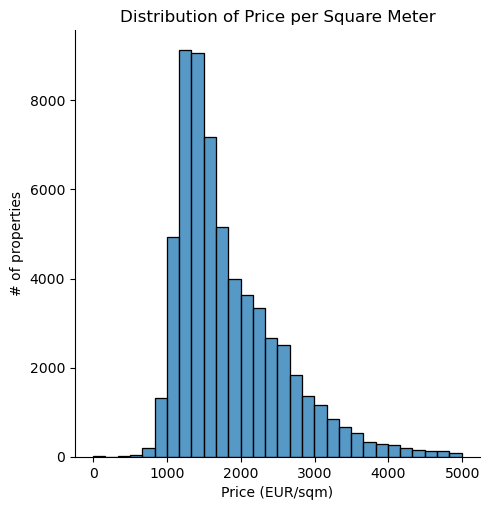

In [156]:
# Calculate the IQR of the price_EUR_sqm column
q1 = real_estate_df['price_EUR_sqm'].quantile(0.25)
q3 = real_estate_df['price_EUR_sqm'].quantile(0.75)
iqr = q3 - q1

# Calculate the upper and lower bounds for outliers
upper_bound = q3 + 3*iqr
lower_bound = q1 - 1.5*iqr

# Remove the outliers from the dataframe
real_estate_df = real_estate_df[(real_estate_df['price_EUR_sqm'] >= lower_bound) & (real_estate_df['price_EUR_sqm'] <= upper_bound)]

# Create a histogram of price_EUR_sqm
sns.displot(data=real_estate_df, x='price_EUR_sqm', bins=30)

# Set the x- and y-axis labels and title
plt.xlabel('Price (EUR/sqm)')
plt.ylabel('# of properties')
plt.title('Distribution of Price per Square Meter')

# Show the plot
plt.show()

In [157]:
# Cast floor_level to int
real_estate_df['floor_level'] = real_estate_df['floor_level'].astype(int)

Push data to SQL Server

In [158]:
# Establish a connection to the SQL Server database
conn = pyodbc.connect(
    'Driver={ODBC Driver 17 for SQL Server};'
    'Server=WRLT0371;' # device or laptop name
    'Database=hibernia;'
    'Trusted_Connection=yes;'
)

cursor = conn.cursor()

# Define the schema and table name
schema_name = 'dbo'
table_name = 'Real_estate_28_Aug_2023'

# Check if the table already exists in the database
cursor.execute(f"IF OBJECT_ID('{schema_name}.{table_name}', 'U') IS NOT NULL SELECT 1 ELSE SELECT 0")
table_exists = cursor.fetchone()[0] == 1

if table_exists:
    print(f"Table '{schema_name}.{table_name}' already exists.")
else:
    # Get the data types from the DataFrame
    dtypes = real_estate_df.dtypes

    # Generate the CREATE TABLE query based on the DataFrame columns and data types
    create_table_query = f"CREATE TABLE {schema_name}.{table_name} (" # define create_table_query initially as a string containing the schema and table name we are going to create
    for column, dtype in dtypes.items():
        column_name = f"[{column}]"  # Enclose column name in square brackets
        if dtype == 'object':
            create_table_query += f"{column_name} VARCHAR(MAX) NULL, "  # Add NULL keyword
        elif dtype == 'int64':
            create_table_query += f"{column_name} INT NULL, "  # Add NULL keyword
        elif dtype == 'float64':
            create_table_query += f"{column_name} FLOAT NULL, "  # Add NULL keyword
        elif dtype == 'bool':
            create_table_query += f"{column_name} BIT NULL, "  # Convert bool to BIT and add NULL keyword
        elif dtype == 'datetime64[ns]':
            create_table_query += f"{column_name} VARCHAR(MAX) NULL, "  # Assuming date columns are stored as strings and add NULL keyword
        else:
            create_table_query += f"{column_name} VARCHAR(MAX) NULL, "  # Assign VARCHAR(MAX) for other data types and add NULL keyword
    create_table_query = create_table_query[:-2] + ")"  # Remove the trailing comma and space

    cursor.execute(create_table_query) # run the query of creating the table with corresponding columns - not that the create_table_query variable is actually assigned a string containing the SQL command
    conn.commit()
    print(f"Table '{schema_name}.{table_name}' created successfully.")

# Insert the data into the table
subset_df = real_estate_df  # Insert the entire dataframe as a subset

for _, row in subset_df.iterrows():
    try:
        values = row.values.tolist()
        for i in range(len(values)):
            if pd.isnull(values[i]):
                values[i] = "NULL"  # Convert NaN values to NULL
            elif isinstance(values[i], float):
                values[i] = str(values[i])  # Convert float values to string representation
            elif isinstance(values[i], str):
                values[i] = values[i].replace("'", "''")  # Escape single quotation marks

        values = ", ".join(["'" + str(value) + "'" for value in values])
        insert_query = f'INSERT INTO {schema_name}.{table_name} VALUES ({values})'
        cursor.execute(insert_query)
        conn.commit()
    except Exception as e:
        print("Error occurred while inserting row:")
        print(row)
        print("Error message:", str(e))
        break

# Close the database connection
conn.close()

Table 'dbo.Real_estate_28_Aug_2023' created successfully.
